<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Predicción de próxima palabra

### Objetivo
El objetivo es utilizar documentos / corpus para crear embeddings de palabras basado en ese contexto utilizando la layer Embedding de Keras. Se utilizará esos embeddings junto con layers LSTM para predeccir la próxima posible palabra.

Se utiliza el texto de la biografía de María Antonieta como corpus para este desafío.

In [1]:
!pip install PyPDF2 -qq
!pip install pycryptodome==3.15.0 -qq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 10.7 MB/s eta 0:00:00


In [2]:
import random
import io
import pickle

import numpy as np
import pandas as pd

from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout

### Datos


In [3]:
import PyPDF2

In [ ]:
# creating a pdf reader object
reader = PyPDF2.PdfReader('./Maria_Antonieta-Zweig_Stefan.pdf')

# print the number of pages in pdf file
print(len(reader.pages))

# print the text of the first page
print(reader.pages[0].extract_text())

In [7]:
texto_raw = ''

# Tomamos el texto a partir de la segunda página para evitar el índice
for p in reader.pages[1:]:
  texto_raw = texto_raw + p.extract_text()

In [8]:
# Se reemplazan caracteres especiales
texto = texto_raw.replace('´ ','').replace('´','').replace('˜ n','ñ').replace('-\n','').replace('ı','i').replace('\n',' ')

In [9]:
# Quitamos la porcion de indice
texto = texto[222:]
texto

'Escribir la historia de l a reina María Antonieta es volver a abrir un proceso más que  secular, en el cual acusadores y defensores se contradicen mutuamente del modo más  violento. Del tono apasionado de la discusión son culpables los acusadores. Para herir a la  realeza, la Revoluci ón tenía que atacar a la reina, y en la reina, a la mujer. Ahora bien.  veracidad y política habitan raramente bajo el mismo techo, y allí donde se traza una ima gen con fines demagógicos, es de esperar poca rectitud de los siervos complacientes de la  opini ón pública. No se ahorró nin guna difamación contra María Antonieta. ningún medio  para llevarla a la guillotina: todo vicio. toda depravación moral, toda suerte de  perversidad fueron atribuidos sin vacilar a la louve autrichienne , a la loba austríaca, en  periódicos, folletos y libros: hasta en la propia morada de la justicia. en la sala del juicio,  comparó el fiscal, patéticamente, a la «Viuda Capeto» con la, viciosas más célebres de la  histori

In [10]:
# Separamos el texto plano en documentos (oraciones)
textos = texto.split('. ')
textos = [t for t in textos if t.__len__() > 6]

In [347]:
# Generamos el dataFrame
df = pd.DataFrame(textos, columns=['Docs'])
df.head()

,Docs
0,Escribir la historia de l a reina María Antoni...
1,Del tono apasionado de la discusión son culpab...
2,"Para herir a la realeza, la Revoluci ón tenía..."
3,Ahora bien
4,veracidad y política habitan raramente bajo e...


In [299]:
df.shape

(5659, 1)

In [295]:
from collections import Counter

# Separamos el texto en palabras
split_it = texto.split()
# Contamos la ocurrencia de las palabras
Counter = Counter(split_it)
# Generamos una lista de palabras mas frecuentes
most_occur = Counter.most_common(1001)[1:]

print(most_occur)

[('la', 7114), ('y', 4799), ('que', 4529), ('a', 4359), ('el', 4256), ('en', 4111), ('su', 2597), ('se', 2385), ('los', 2303), ('no', 1989), ('con', 1931), ('un', 1801), ('por', 1792), ('una', 1664), ('las', 1641), ('del', 1363), ('más', 1324), ('para', 1273), ('al', 1095), ('es', 1062), ('lo', 1005), ('sus', 898), ('ha', 888), ('como', 883), ('María', 823), ('le', 747), ('este', 575), ('esta', 555), ('ya', 515), ('Antonieta', 472), ('reina', 467), ('todo', 462), ('Pero', 456), ('sin', 437), ('o', 436), ('ni', 408), ('ser', 393), ('toda', 392), ('hasta', 389), ('sólo', 374), ('está', 367), ('rey', 351), ('tiene', 349), ('si', 327), ('vez', 313), ('tan', 307), ('pero', 305), ('han', 293), ('todos', 285), ('En', 284), ('La', 279), ('sobre', 277), ('sino', 266), ('Luis', 261), ('desde', 258), ('mismo', 253), ('todas', 252), ('ella', 249), ('puede', 246), ('y,', 242), ('hace', 242), ('El', 241), ('son', 230), ('tiempo', 230), ('modo', 225), ('siempre', 223), ('ahora', 223), ('cuando', 222)

In [300]:
# Capturamos el vocabulario mas frecuente
vocabulario = [m[0] for m in most_occur]
vocabulario.__len__()

1000

In [449]:
# Función para puntuar las observaciones de acuerdo al uso de palabras del vocabulario
def get_score(x):
  set_x = set(x.split())
  set_voc = set(vocabulario[50:])

  no_voc = set_x - set_voc
  return len(no_voc)

In [348]:
# Filtramos las oraciones con mas cantidad de estas palabras
df['score'] = df.Docs.apply(lambda x: get_score(x))

In [349]:
df

,Docs,score
0,Escribir la historia de l a reina María Antoni...,23
1,Del tono apasionado de la discusión son culpab...,8
2,"Para herir a la realeza, la Revoluci ón tenía...",10
3,Ahora bien,0
4,veracidad y política habitan raramente bajo e...,24
...,...,...
5654,12 octubre Primer interrogatorio a María ...,5
5655,15 octubre Comienza la vista de la causa,4
5656,16 octubre Ejecución de la reina,5
5657,1795: 8 junio Presunta muerte del delfín...,6


In [351]:
# Nos quedamos con las oraciones que tengan hasta 10 palabras fuera del vocabulario
df1 = df.copy()
df1 = df1[df1['score'] <= 10]
df1.shape

(1364, 2)

In [352]:
df = df1

### 1 - Ejemplo de Preprocesamiento
- Hay que transformar las oraciones en tokens.
- Dichas oraciones hay que ajustarlas al tamaño fijo de nuestra sentencia de entrada al modelo.
- Hay que separar las palabras objetivos (target) que el modelo debe predecir en cada sentencia armada.

In [13]:
from keras.preprocessing.text import Tokenizer # equivalente a ltokenizer de nltk
from keras.preprocessing.text import text_to_word_sequence # equivalente a word_tokenize de nltk
from keras.utils import pad_sequences # se utilizará para padding

# largo de la secuencia, incluye seq input + word output
train_len = 6

In [14]:
# Ejemplo de como transformar una oración a tokens usando keras
text = df.loc[0,'Docs']
text

'Escribir la historia de l a reina María Antonieta es volver a abrir un proceso más que  secular, en el cual acusadores y defensores se contradicen mutuamente del modo más  violento'

In [15]:
tokens = text_to_word_sequence(text) # entran oraciones -> salen vectores de N posiciones (tokens)
tokens

['escribir',
 'la',
 'historia',
 'de',
 'l',
 'a',
 'reina',
 'maría',
 'antonieta',
 'es',
 'volver',
 'a',
 'abrir',
 'un',
 'proceso',
 'más',
 'que',
 'secular',
 'en',
 'el',
 'cual',
 'acusadores',
 'y',
 'defensores',
 'se',
 'contradicen',
 'mutuamente',
 'del',
 'modo',
 'más',
 'violento']

1.1 - Transformar las oraciones en secuencias (tokens) de palabras

In [16]:
# Recorrer todas las filas y transformar las oraciones
# en secuencias de palabras
sentence_tokens = []
for _, row in df[:None].iterrows():
    sentence_tokens.append(text_to_word_sequence(row[0]))

In [17]:
# Demos un vistazo
sentence_tokens[:2]

[['escribir',
  'la',
  'historia',
  'de',
  'l',
  'a',
  'reina',
  'maría',
  'antonieta',
  'es',
  'volver',
  'a',
  'abrir',
  'un',
  'proceso',
  'más',
  'que',
  'secular',
  'en',
  'el',
  'cual',
  'acusadores',
  'y',
  'defensores',
  'se',
  'contradicen',
  'mutuamente',
  'del',
  'modo',
  'más',
  'violento'],
 ['del',
  'tono',
  'apasionado',
  'de',
  'la',
  'discusión',
  'son',
  'culpables',
  'los',
  'acusadores']]

In [18]:
# Código para hacer el desfasaje de las palabras
# según el train_len
text_sequences = []

for i in range(train_len, len(tokens)):
  seq = tokens[i-train_len:i]
  text_sequences.append(seq)

In [19]:
# Demos un vistazo a nuestros vectores para entrenar el modelo
text_sequences

[['escribir', 'la', 'historia', 'de'],
 ['la', 'historia', 'de', 'l'],
 ['historia', 'de', 'l', 'a'],
 ['de', 'l', 'a', 'reina'],
 ['l', 'a', 'reina', 'maría'],
 ['a', 'reina', 'maría', 'antonieta'],
 ['reina', 'maría', 'antonieta', 'es'],
 ['maría', 'antonieta', 'es', 'volver'],
 ['antonieta', 'es', 'volver', 'a'],
 ['es', 'volver', 'a', 'abrir'],
 ['volver', 'a', 'abrir', 'un'],
 ['a', 'abrir', 'un', 'proceso'],
 ['abrir', 'un', 'proceso', 'más'],
 ['un', 'proceso', 'más', 'que'],
 ['proceso', 'más', 'que', 'secular'],
 ['más', 'que', 'secular', 'en'],
 ['que', 'secular', 'en', 'el'],
 ['secular', 'en', 'el', 'cual'],
 ['en', 'el', 'cual', 'acusadores'],
 ['el', 'cual', 'acusadores', 'y'],
 ['cual', 'acusadores', 'y', 'defensores'],
 ['acusadores', 'y', 'defensores', 'se'],
 ['y', 'defensores', 'se', 'contradicen'],
 ['defensores', 'se', 'contradicen', 'mutuamente'],
 ['se', 'contradicen', 'mutuamente', 'del'],
 ['contradicen', 'mutuamente', 'del', 'modo'],
 ['mutuamente', 'del', 'mo

1.2 - Crear los vectores de palabras (word2vec)

Ahora necesitamos pasarlos a números para que lo entienda la red y separar input de output.
- El Input seran integers (word2vec)
- Mientras que el output será one hot encodeado (labels) del tamaño del vocabulario

In [20]:
tok = Tokenizer()

# El tokenizer "aprende" las palabras que se usaran
# Se construye (fit) una vez por proyecto, se aplica N veces (tal cual un encoder)
# El token 0 es reservado y no es asignado, esta sutileza nos dará un pequeño
# problema al momento de hacer la codificación OHE, pero es sencillo de resolver
tok.fit_on_texts(text_sequences)

# Convertimos las palabras a números
# entran palabras -> salen números
sequences = tok.texts_to_sequences(text_sequences)

In [21]:
# Ahora sequences tiene los números "ID", largo 4
sequences

[[28, 26, 24, 3],
 [26, 24, 3, 4],
 [24, 3, 4, 1],
 [3, 4, 1, 5],
 [4, 1, 5, 6],
 [1, 5, 6, 7],
 [5, 6, 7, 8],
 [6, 7, 8, 9],
 [7, 8, 9, 1],
 [8, 9, 1, 10],
 [9, 1, 10, 11],
 [1, 10, 11, 12],
 [10, 11, 12, 2],
 [11, 12, 2, 13],
 [12, 2, 13, 14],
 [2, 13, 14, 15],
 [13, 14, 15, 16],
 [14, 15, 16, 17],
 [15, 16, 17, 18],
 [16, 17, 18, 19],
 [17, 18, 19, 20],
 [18, 19, 20, 21],
 [19, 20, 21, 22],
 [20, 21, 22, 23],
 [21, 22, 23, 25],
 [22, 23, 25, 27],
 [23, 25, 27, 2]]

In [22]:
# Cantidad de casos (doc) de entrada
print(tok.document_count)

27


In [23]:
# Cantidad de veces que aparece cada palabra
print(len(tok.word_counts))

28


In [24]:
# El índice para cada palabra
# El sistema las ordena de las más populares a las menos populares
print(tok.word_index)

{'a': 1, 'más': 2, 'de': 3, 'l': 4, 'reina': 5, 'maría': 6, 'antonieta': 7, 'es': 8, 'volver': 9, 'abrir': 10, 'un': 11, 'proceso': 12, 'que': 13, 'secular': 14, 'en': 15, 'el': 16, 'cual': 17, 'acusadores': 18, 'y': 19, 'defensores': 20, 'se': 21, 'contradicen': 22, 'mutuamente': 23, 'historia': 24, 'del': 25, 'la': 26, 'modo': 27, 'escribir': 28}


In [25]:
# Cantidad de veces quea aparece cada palabra en cada "documento"
# (1 documento = 1 caso de entrada)
print(tok.word_docs)

defaultdict(<class 'int'>, {'escribir': 1, 'de': 4, 'historia': 3, 'la': 2, 'l': 4, 'a': 8, 'reina': 4, 'maría': 4, 'antonieta': 4, 'es': 4, 'volver': 4, 'abrir': 4, 'un': 4, 'proceso': 4, 'más': 5, 'que': 4, 'secular': 4, 'en': 4, 'el': 4, 'cual': 4, 'acusadores': 4, 'y': 4, 'defensores': 4, 'se': 4, 'contradicen': 4, 'mutuamente': 4, 'del': 3, 'modo': 2})


### 2 - Preprocesamiento completo
Debemos realizar los mismos pasos que en el ejemplo anterior, pero antes de eso debemos transformar ese dataset de filas de oraciones en un texto completo continuo para poder extraer el vocabulario.

In [450]:
df

,Docs,score
1,Del tono apasionado de la discusión son culpab...,8
2,"Para herir a la realeza, la Revoluci ón tenía...",10
3,Ahora bien,0
5,No se ahorró nin guna difamación contra María ...,6
6,ningún medio para llevarla a la guillotina: t...,7
...,...,...
5654,12 octubre Primer interrogatorio a María ...,5
5655,15 octubre Comienza la vista de la causa,4
5656,16 octubre Ejecución de la reina,5
5657,1795: 8 junio Presunta muerte del delfín...,6


In [451]:
# Vistazo a las primeras filas
df.loc[:15,'Docs']

1     Del tono apasionado de la discusión son culpab...
2     Para herir a la  realeza, la Revoluci ón tenía...
3                                            Ahora bien
5     No se ahorró nin guna difamación contra María ...
6     ningún medio  para llevarla a la guillotina: t...
9     Tanto más completo fue d espués el  cambio, cu...
10                                              en 1815
14                                      su magnanimidad
15                               su heroísmo inmaculado
Name: Docs, dtype: object

In [452]:
# Concatenamos todos los rows en un solo valor
corpus = df.apply(lambda row: ' '.join(row.values.astype(str)), axis=0)[0]
corpus

'Del tono apasionado de la discusión son culpables los acusadores Para herir a la  realeza, la Revoluci ón tenía que atacar a la reina, y en la reina, a la mujer Ahora bien No se ahorró nin guna difamación contra María Antonieta ningún medio  para llevarla a la guillotina: todo vicio Tanto más completo fue d espués el  cambio, cuando en 1815  su magnanimidad su heroísmo inmaculado son celebrados en verso y e n prosa y un velo  de anécdotas abundantemente impregnadas en llanto, tejido Como reina, la habrían sepultado solemnemente se encuentran en las no leídas pág inas del Ghota y -esto es lo esen cial- jamás si no hubiese  estado sometida a esta prueba  habría sabido ni experimentado ella misma María  Antonieta reina de Francia, cómo era en realidad su persona   Pues ¡con qué arte, con qué fuerza de invención en los epi sodios en qué inmensidad de  impresionantes dimensiones uni versales introduce aquí la historia en su drama se defiende y no  quiere entregarse, gime, se escon de, trat

In [355]:
# Transformar el corpus a tokens
tokens=text_to_word_sequence(corpus)
# Vistazo general de los primeros tokens
tokens[:20]

['del',
 'tono',
 'apasionado',
 'de',
 'la',
 'discusión',
 'son',
 'culpables',
 'los',
 'acusadores',
 'para',
 'herir',
 'a',
 'la',
 'realeza',
 'la',
 'revoluci',
 'ón',
 'tenía',
 'que']

In [356]:
print("Cantidad de tokens en el corpus:", len(tokens))

Cantidad de tokens en el corpus: 13794


In [395]:
# Código para hacer el desfasaje de las palabras
# según el train_len

text_sequences = []
for i in range(train_len, len(tokens)):
  seq = tokens[i-train_len:i]
  text_sequences.append(seq)

In [396]:
# Demos un vistazo a nuestros vectores para entrenar el modelo
text_sequences[:20]

[['del', 'tono', 'apasionado', 'de', 'la', 'discusión'],
 ['tono', 'apasionado', 'de', 'la', 'discusión', 'son'],
 ['apasionado', 'de', 'la', 'discusión', 'son', 'culpables'],
 ['de', 'la', 'discusión', 'son', 'culpables', 'los'],
 ['la', 'discusión', 'son', 'culpables', 'los', 'acusadores'],
 ['discusión', 'son', 'culpables', 'los', 'acusadores', 'para'],
 ['son', 'culpables', 'los', 'acusadores', 'para', 'herir'],
 ['culpables', 'los', 'acusadores', 'para', 'herir', 'a'],
 ['los', 'acusadores', 'para', 'herir', 'a', 'la'],
 ['acusadores', 'para', 'herir', 'a', 'la', 'realeza'],
 ['para', 'herir', 'a', 'la', 'realeza', 'la'],
 ['herir', 'a', 'la', 'realeza', 'la', 'revoluci'],
 ['a', 'la', 'realeza', 'la', 'revoluci', 'ón'],
 ['la', 'realeza', 'la', 'revoluci', 'ón', 'tenía'],
 ['realeza', 'la', 'revoluci', 'ón', 'tenía', 'que'],
 ['la', 'revoluci', 'ón', 'tenía', 'que', 'atacar'],
 ['revoluci', 'ón', 'tenía', 'que', 'atacar', 'a'],
 ['ón', 'tenía', 'que', 'atacar', 'a', 'la'],
 ['ten

In [ ]:
for t in text_sequences:
  if t.__len__() != 4:
    print('e')

In [398]:
# Proceso de tokenización
tok = Tokenizer(num_words=None,
    filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
    lower=True,
    split=' ',
    char_level=False,
    oov_token=None,
    analyzer=None)

tok.fit_on_texts(text_sequences)

# Convertimos las palabras a números
# entran palabras -> salen números
sequences = tok.texts_to_sequences(text_sequences)

# Damos un vistazo
# sequences[:20]
sequences = np.array(sequences)

In [399]:
type(sequences)

numpy.ndarray

In [400]:
tok.word_counts.keys().__len__()

3742

In [401]:
print("Cantidad de rows del dataset:", len(sequences))

Cantidad de rows del dataset: 13788


### 3 - Input y target

In [402]:
# Con numpy es muy fácil realizar el slicing de vectores
ex = np.array([[1,2,3,4],[5,6,7,8]])
ex

array([[1, 2, 3, 4],
       [5, 6, 7, 8]])

In [403]:
# Con numpy es muy fácil realizar el slicing de vectores
print("Dimension:", ex.shape)
print("Todos los elementos:", ex)
print("Todos los elementos menos el último:", ex[:, :-1])

Dimension: (2, 4)
Todos los elementos: [[1 2 3 4]
 [5 6 7 8]]
Todos los elementos menos el último: [[1 2 3]
 [5 6 7]]


In [404]:
input = ex[:,:-1] # todos los rows, menos la ultima col
target = ex[:, -1] # última col de cada row

print("Input:", input)
print("Target:", target)

Input: [[1 2 3]
 [5 6 7]]
Target: [4 8]


In [405]:
arr_sequences = np.array(sequences)
x_data = arr_sequences[:,:-1]
y_data_int = arr_sequences[:,-1] # aún falta el oneHotEncoder

print(x_data.shape)
print(y_data_int.shape)

(13788, 5)
(13788,)


In [406]:
# Palabras del vocabulario
tok.index_word.__len__()

3742

In [407]:
# Cantidad de palabras en el vocabulario
vocab_size = len(tok.word_counts)
vocab_size

3742

In [408]:
y_data_int.shape

(13788,)

In [409]:
# En el caso anterior explota porque y_data_int comienza en "1" en vez de "0"
# valor minimo:
min(y_data_int)

1

In [410]:
y_data_int_offset = y_data_int - 1
y_data = to_categorical(y_data_int_offset, num_classes=vocab_size)
y_data.shape

(13788, 3742)

### 4 - Entrenar el modelo

In [411]:
# largo de la secuencia de entrada
input_seq_len = x_data.shape[1]
input_seq_len

5

In [412]:
# Largo del vector de salida --> vocab_size
output_size = vocab_size
output_size

3742

In [413]:
from keras.layers import Bidirectional

In [414]:
input_shape = np.array(sequences).shape

In [415]:
input_shape = x_data[0].shape

In [423]:
input_shape

(5,)

In [431]:
model = Sequential()

# Embedding:
# input_seq_len = 3 --> ingreso 3 palabras
# input_dim = vocab_size --> 1628 palabras distintas
# output_dim = 5 --> crear embeddings de tamaño 3 (tamaño variable y ajustable)
model.add(Embedding(input_dim=vocab_size+1, output_dim=8, input_length=input_seq_len))
model.add(Bidirectional(LSTM(64, activation='relu', return_sequences=True), input_shape=input_shape))
# model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(64, activation='relu'), input_shape=input_shape))
# model.add(LSTM(64)) # La última capa LSTM no lleva return_sequences
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))
# Predicción de clasificación con softmax
# La salida vuelve al espacio de 1628 palabras posibles
model.add(Dense(vocab_size, activation='softmax'))

# Clasificación multiple categórica --> loss = categorical_crossentropy
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()


Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 5, 8)              29944     
                                                                 
 bidirectional_18 (Bidirect  (None, 5, 128)            37376     
 ional)                                                          
                                                                 
 dropout_24 (Dropout)        (None, 5, 128)            0         
                                                                 
 bidirectional_19 (Bidirect  (None, 128)               98816     
 ional)                                                          
                                                                 
 dense_27 (Dense)            (None, 128)               16512     
                                                                 
 dropout_25 (Dropout)        (None, 128)              

In [432]:
x_data.shape, y_data.shape

((13788, 5), (13788, 3742))

In [433]:
hist = model.fit(x_data, y_data, epochs=10, validation_split=0.2)

Epoch 1/10
345/345 [==============================] - 56s 134ms/step - loss: 6.9820 - accuracy: 0.0430 - val_loss: 7.0933 - val_accuracy: 0.0533
Epoch 2/10
345/345 [==============================] - 41s 120ms/step - loss: 6.5603 - accuracy: 0.0407 - val_loss: 7.2808 - val_accuracy: 0.0518
Epoch 3/10
345/345 [==============================] - 40s 117ms/step - loss: 6.4111 - accuracy: 0.0422 - val_loss: 7.4562 - val_accuracy: 0.0533
Epoch 4/10
345/345 [==============================] - 40s 114ms/step - loss: 6.2762 - accuracy: 0.0451 - val_loss: 7.5938 - val_accuracy: 0.0667
Epoch 5/10
345/345 [==============================] - 41s 118ms/step - loss: 6.1277 - accuracy: 0.0494 - val_loss: 7.9623 - val_accuracy: 0.0613
Epoch 6/10
345/345 [==============================] - 42s 121ms/step - loss: 6.0031 - accuracy: 0.0552 - val_loss: 8.3547 - val_accuracy: 0.0606
Epoch 7/10
345/345 [==============================] - 34s 100ms/step - loss: 5.9142 - accuracy: 0.0612 - val_loss: 9.0112 - val_ac

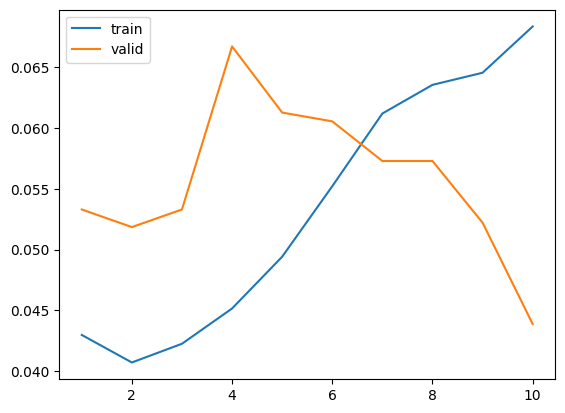

In [434]:
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento
epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist.history['val_accuracy'], label='valid')
plt.show()

### 5 - Predicción de próxima palabra

In [51]:
# Keras pad_sequences
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences
# Si la secuencia de entrada supera al input_seq_len (3) se trunca
# Si la secuencia es más corta se agregna ceros al comienzo

In [ ]:
# Se utilizará gradio para ensayar el modelo
# Herramienta poderosa para crear interfaces rápidas para ensayar modelos
# https://gradio.app/
import sys
!{sys.executable} -m pip install gradio --quiet

In [ ]:
import gradio as gr

def model_response(human_text):

    # Encodeamos
    encoded = tok.texts_to_sequences([human_text])[0]
    # Si tienen distinto largo
    encoded = pad_sequences([encoded], maxlen=3, padding='pre')

    # Predicción softmax
    y_hat = model.predict(encoded).argmax(axis=-1)

    # Debemos buscar en el vocabulario la palabra
    # que corresopnde al indice (y_hat) predicho por le modelo
    out_word = ''
    for word, index in tok.word_index.items():
        if index == y_hat:
            out_word = word
            break

    # Agrego la palabra a la frase predicha
    return human_text + ' ' + out_word

iface = gr.Interface(
    fn=model_response,
    inputs=["textbox"],
    outputs="text",
    layout="vertical")

iface.launch(debug=True)

### 6 - Generación de secuencias nuevas

In [436]:
def generate_seq(model, tokenizer, seed_text, max_length, n_words):
    """
        Exec model sequence prediction

        Args:
            model (keras): modelo entrenado
            tokenizer (keras tokenizer): tonenizer utilizado en el preprocesamiento
            seed_text (string): texto de entrada (input_seq)
            max_length (int): máxima longitud de la sequencia de entrada
            n_words (int): números de palabras a agregar a la sequencia de entrada
        returns:
            output_text (string): sentencia con las "n_words" agregadas
    """
    output_text = seed_text
	# generate a fixed number of words
    for _ in range(n_words):
		# Encodeamos
        encoded = tokenizer.texts_to_sequences([output_text])[0]
		# Si tienen distinto largo
        encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

		# Predicción softmax
        y_hat = model.predict(encoded).argmax(axis=-1)
		# Vamos concatenando las predicciones
        out_word = ''

        # Debemos buscar en el vocabulario la palabra
        # que corresopnde al indice (y_hat) predicho por le modelo
        for word, index in tokenizer.word_index.items():
            if index == y_hat:
                out_word = word
                break

		# Agrego las palabras a la frase predicha
        output_text += ' ' + out_word
    return output_text

In [439]:
input_text='ella no estaba pero cuando llegaron a '

generate_seq(model, tok, input_text, max_length=5, n_words=15)

1/1 [==============================] - 0s 23ms/step


'ella no estaba pero cuando llegaron a  de se para se para se para se para se para se para se para'

### 7 - Beam search y muestreo aleatorio

In [442]:
# funcionalidades para hacer encoding y decoding

def encode(text,max_length=5):

    encoded = tok.texts_to_sequences([text])[0]
    encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

    return encoded

def decode(seq):
    return tok.sequences_to_texts([seq])

In [446]:
from scipy.special import softmax

# función que selecciona candidatos para el beam search
def select_candidates(pred,num_beams,vocab_size,history_probs,history_tokens,temp=1,muestreo=True):

  # colectar todas las probabilidades para la siguiente búsqueda
  pred_large = []

  for idx,pp in enumerate(pred):
    pred_large.extend(np.log(pp+1E-10)+history_probs[idx])

  pred_large = np.array(pred_large)

  # criterio de selección
  if muestreo:
    idx_select = np.random.choice(np.arange(pred_large.shape[0]), num_beams, p=softmax(pred_large/temp)) # beam search con muestreo
  else:
    idx_select = np.argsort(pred_large)[::-1][:num_beams] # beam search determinista


  # traducir a índices de token en el vocabulario
  new_history_tokens = np.concatenate((np.array(history_tokens)[idx_select//vocab_size],
                        np.array([idx_select%vocab_size]).T),
                      axis=1)

  # devolver el producto de las probabilidades (log) y la secuencia de tokens seleccionados
  return pred_large[idx_select.astype(int)], new_history_tokens.astype(int)


def beam_search(model,num_beams,num_words,input, muestreo=True):

    # first iteration

    # encode
    encoded = encode(input)

    # first prediction
    y_hat = np.squeeze(model.predict(encoded))

    # get vocabulary size
    vocab_size = y_hat.shape[0]

    # initialize history
    history_probs = [0]*num_beams
    history_tokens = [encoded[0]]*num_beams

    # select num_beams candidates
    history_probs, history_tokens = select_candidates([y_hat],
                                        num_beams,
                                        vocab_size,
                                        history_probs,
                                        history_tokens,
                                        muestreo=muestreo)

    # beam search loop
    for i in range(num_words-1):

      preds = []

      for hist in history_tokens:

        # actualizar secuencia de tokens
        input_update = np.array([hist[i+1:]]).copy()

        # predicción
        y_hat = np.squeeze(model.predict(input_update))

        preds.append(y_hat)

      history_probs, history_tokens = select_candidates(preds,
                                                        num_beams,
                                                        vocab_size,
                                                        history_probs,
                                                        history_tokens)

    return history_tokens

In [447]:
# predicción con beam search
salidas = beam_search(model,num_beams=10,num_words=16,input='en Francia no habia', muestreo=True)
# veamos las salidas
decode(salidas[0])

1/1 [==============================] - 0s 77ms/step


['en francia no digas lo de aún nombre ha sentido nada la piensa escucha se ejércitos']

In [448]:
# predicción con beam search
salidas = beam_search(model,num_beams=10,num_words=16,input='en Francia no habia', muestreo=False)
# veamos las salidas
decode(salidas[0])

1/1 [==============================] - 0s 24ms/step


['en francia no sin punto rey en no un incapacidad de nada reina lo desde ahora no reglamentado']

### 8 - Conclusiones
Cuestiones que se mejoraron:
- Agregar más capas o neuronaes
- Incrementar la cantidad de épocas
- Agregar BRNN

Se implementa una lógica de filtrado de observaciones para quedarse con las oraciones que emplean la mayor cantidad de palabras del vocabulario.


Se observa una falta de coherencia en la predicción de próxima palabra, esto se debe a lo reducido del corpus utilizado.